##Get the dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2022-07-04 22:23:28--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   287MB/s    in 0.2s    

2022-07-04 22:23:28 (287 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



##Unzip the dataset

In [ ]:
!unzip cats_and_dogs_filtered.zip

##Get the models from TensorFlow Hub

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
from tensorflow.keras.preprocessing import image

In [5]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

##Create a classifier with mobilenet model

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
    
])

In [7]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [8]:
import numpy as np

##Load a random image from the dataset and process it

In [9]:
test_image = image.load_img('/content/cats_and_dogs_filtered/validation/cats/cat.2008.jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
test_image = test_image / 255.

##Make a prediction with the model

In [10]:
result = classifier.predict(test_image)
result.shape

(1, 1001)

##Get the maximum value of the result

In [11]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=286>

##Download ImageNet labels

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


##Print the predicted class

In [13]:
predicted_class_name = imagenet_labels[predicted_class]

In [14]:
predicted_class_name

'Egyptian cat'

##Load the dataset to memory using image_dataset_from_directory() function

In [15]:
import os, shutil, pathlib

In [16]:
base_dir= pathlib.Path("cats_and_dogs_filtered")

In [17]:
image_size=(224, 224)
batch_size=32

In [18]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [19]:
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    seed=123,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)

Found 1000 files belonging to 2 classes.


In [20]:
test_dataset = image_dataset_from_directory(
    base_dir / "train",
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 400 files for validation.


##Print class_names

In [21]:
import numpy as np
class_names = np.array(train_dataset.class_names)
print(class_names)

['cats' 'dogs']


##Get the mobilenet model using hub.KerasLayer()

In [22]:
feature_extractor = hub.KerasLayer(mobilenet_v2 ,
                                   input_shape=(224, 224 ,3))

In [23]:
feature_extractor.trainable = False

In [24]:
import matplotlib.pylab as plt

In [26]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_1 (Dense)             (None, 2)                 2004      
                                                                 
Total params: 3,542,269
Trainable params: 2,004
Non-trainable params: 3,540,265
_________________________________________________________________


In [27]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 15
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/15
50/50 [==============================] - 10s 103ms/step - loss: 0.7396 - accuracy: 0.5919 - val_loss: 0.6183 - val_accuracy: 0.6510
Epoch 2/15
50/50 [==============================] - 5s 87ms/step - loss: 0.6484 - accuracy: 0.6550 - val_loss: 0.6705 - val_accuracy: 0.6320
Epoch 3/15
50/50 [==============================] - 5s 90ms/step - loss: 0.5990 - accuracy: 0.6725 - val_loss: 0.5784 - val_accuracy: 0.6930
Epoch 4/15
50/50 [==============================] - 5s 89ms/step - loss: 0.5842 - accuracy: 0.6981 - val_loss: 0.5784 - val_accuracy: 0.6860
Epoch 5/15
50/50 [==============================] - 5s 87ms/step - loss: 0.5679 - accuracy: 0.7006 - val_loss: 0.5832 - val_accuracy: 0.6790
Epoch 6/15
50/50 [==============================] - 5s 87ms/step - loss: 0.5624 - accuracy: 0.7138 - val_loss: 0.5658 - val_accuracy: 0.6920
Epoch 7/15
50/50 [==============================] - 5s 87ms/step - loss: 0.5554 - accuracy: 0.7100 - val_loss: 0.6216 - val_accuracy: 0.6580
Epoch 8/15


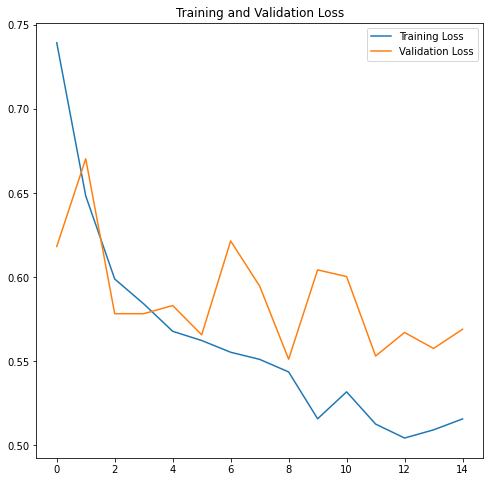

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

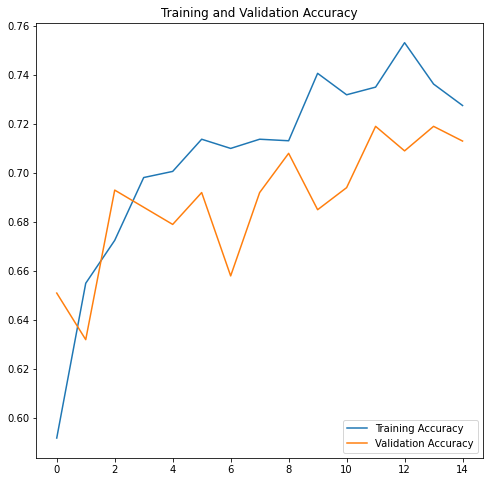

In [29]:
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

##Using data augmentation

In [30]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

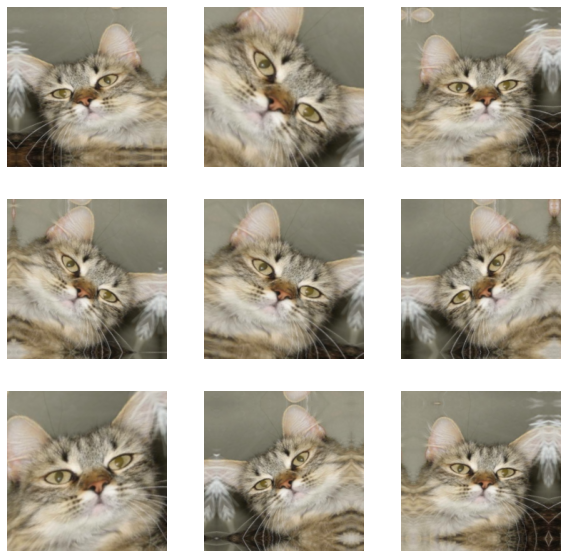

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

##We use data augmentation and rescale images to the [0, 1] range

In [33]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  feature_extractor,
  tf.keras.layers.Dense(2, activation="softmax")
])

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [36]:
EPOCHS = 15
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/15
50/50 [==============================] - 8s 100ms/step - loss: 0.1799 - accuracy: 0.9300 - val_loss: 0.0689 - val_accuracy: 0.9740
Epoch 2/15
50/50 [==============================] - 5s 91ms/step - loss: 0.0981 - accuracy: 0.9631 - val_loss: 0.0524 - val_accuracy: 0.9830
Epoch 3/15
50/50 [==============================] - 5s 91ms/step - loss: 0.0855 - accuracy: 0.9675 - val_loss: 0.0482 - val_accuracy: 0.9830
Epoch 4/15
50/50 [==============================] - 5s 91ms/step - loss: 0.0818 - accuracy: 0.9656 - val_loss: 0.0464 - val_accuracy: 0.9830
Epoch 5/15
50/50 [==============================] - 5s 91ms/step - loss: 0.0554 - accuracy: 0.9781 - val_loss: 0.0412 - val_accuracy: 0.9850
Epoch 6/15
50/50 [==============================] - 5s 92ms/step - loss: 0.0523 - accuracy: 0.9769 - val_loss: 0.0460 - val_accuracy: 0.9860
Epoch 7/15
50/50 [==============================] - 6s 112ms/step - loss: 0.0532 - accuracy: 0.9806 - val_loss: 0.0435 - val_accuracy: 0.9850
Epoch 8/15


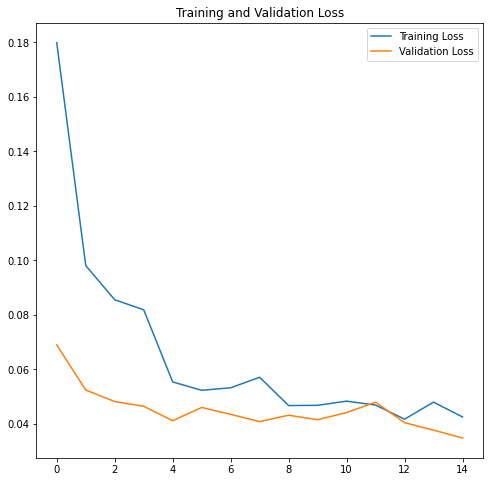

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

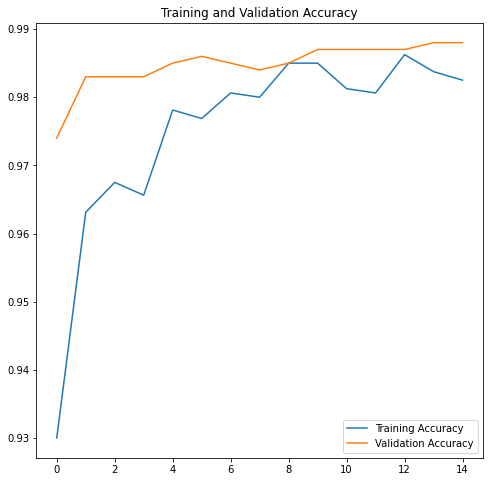

In [38]:
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

##Fine tune the model

In [43]:
feature_extractor_new = hub.KerasLayer(mobilenet_v2,
                                   input_shape=(224, 224 ,3))
feature_extractor_new.trainable = True

In [49]:
for i in range(len(feature_extractor_new.weights)):
    print("In layer ",feature_extractor_new.weights[i].name," the content is: ", feature_extractor_new.weights[i])

Streaming output truncated to the last 5000 lines.
        9.78832722e-01,  1.83463776e+00,  4.84105110e-01,  2.64283687e-01,
        1.74495414e-01, -1.49238333e-01,  7.21079409e-01,  2.49586836e-01,
       -9.19349790e-02, -8.11377645e-01,  7.11902618e-01, -2.48793817e+00,
        1.27723604e-01, -1.77819169e+00, -7.33087063e-01, -5.21801645e-03,
        4.26944584e-01, -2.25654110e-01, -5.32555401e-01,  2.84707993e-01,
        2.33681411e-01,  1.03763163e+00, -2.67464876e+00,  4.29125816e-01,
        4.49593931e-01,  1.70757771e-01, -1.45617938e+00,  1.43940553e-01,
        3.67184542e-02, -2.90844703e+00, -5.48077971e-02, -3.39962959e-01,
        1.13975808e-01, -7.31362343e-01,  1.80615932e-01,  5.95604658e-01,
        1.31455675e-01,  1.52144536e-01,  3.55532527e-01, -1.10605049e+00],
      dtype=float32)>
In layer  MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0  the content is:  <tf.Variable 'MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0' shape=(320,

In [51]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  feature_extractor_new,
  tf.keras.layers.Dense(2, activation="softmax")
])

In [52]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [53]:
EPOCHS = 15
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/15
50/50 [==============================] - 23s 288ms/step - loss: 0.6221 - accuracy: 0.8600 - val_loss: 1.9794 - val_accuracy: 0.9240
Epoch 2/15
50/50 [==============================] - 14s 272ms/step - loss: 0.4214 - accuracy: 0.9013 - val_loss: 10.1451 - val_accuracy: 0.6250
Epoch 3/15
50/50 [==============================] - 14s 269ms/step - loss: 0.2613 - accuracy: 0.9450 - val_loss: 0.5242 - val_accuracy: 0.9230
Epoch 4/15
50/50 [==============================] - 14s 272ms/step - loss: 0.2758 - accuracy: 0.9425 - val_loss: 0.5473 - val_accuracy: 0.9250
Epoch 5/15
50/50 [==============================] - 14s 267ms/step - loss: 0.2562 - accuracy: 0.9506 - val_loss: 0.3598 - val_accuracy: 0.9420
Epoch 6/15
50/50 [==============================] - 14s 273ms/step - loss: 0.2239 - accuracy: 0.9669 - val_loss: 0.2981 - val_accuracy: 0.9450
Epoch 7/15
50/50 [==============================] - 14s 270ms/step - loss: 0.2288 - accuracy: 0.9581 - val_loss: 0.2538 - val_accuracy: 0.955

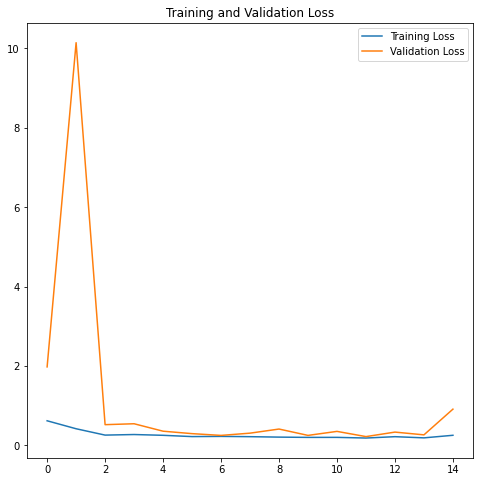

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

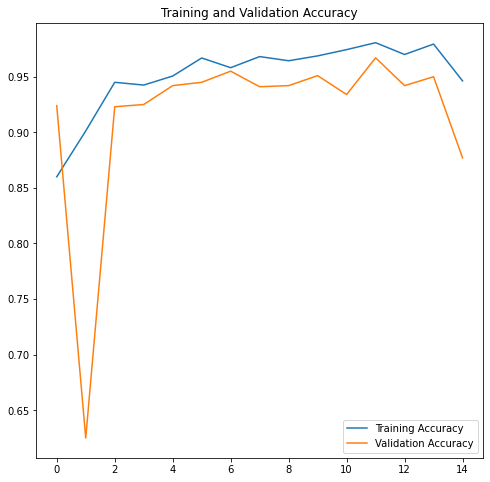

In [55]:
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [75]:
conv_base  = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [76]:
conv_base.trainable = True

In [59]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Freeze all layers until the 4th from the last

In [77]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [82]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [83]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [84]:
EPOCHS = 30
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                   validation_data=validation_dataset)

Epoch 1/30
50/50 [==============================] - 18s 330ms/step - loss: 3.2914 - accuracy: 0.7606 - val_loss: 0.6815 - val_accuracy: 0.9270
Epoch 2/30
50/50 [==============================] - 17s 328ms/step - loss: 1.0764 - accuracy: 0.8888 - val_loss: 0.3382 - val_accuracy: 0.9570
Epoch 3/30
50/50 [==============================] - 16s 319ms/step - loss: 0.6187 - accuracy: 0.9212 - val_loss: 0.2434 - val_accuracy: 0.9630
Epoch 4/30
50/50 [==============================] - 16s 318ms/step - loss: 0.4228 - accuracy: 0.9350 - val_loss: 0.1969 - val_accuracy: 0.9690
Epoch 5/30
50/50 [==============================] - 16s 320ms/step - loss: 0.2726 - accuracy: 0.9463 - val_loss: 0.1683 - val_accuracy: 0.9690
Epoch 6/30
50/50 [==============================] - 16s 321ms/step - loss: 0.2113 - accuracy: 0.9544 - val_loss: 0.1445 - val_accuracy: 0.9730
Epoch 7/30
50/50 [==============================] - 16s 322ms/step - loss: 0.1819 - accuracy: 0.9669 - val_loss: 0.1274 - val_accuracy: 0.9730

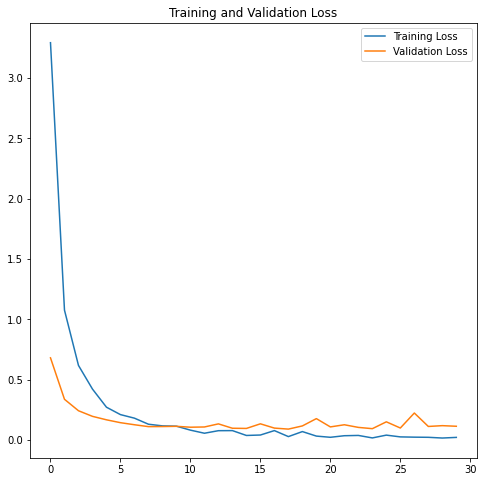

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Training and Validation Accuracy')

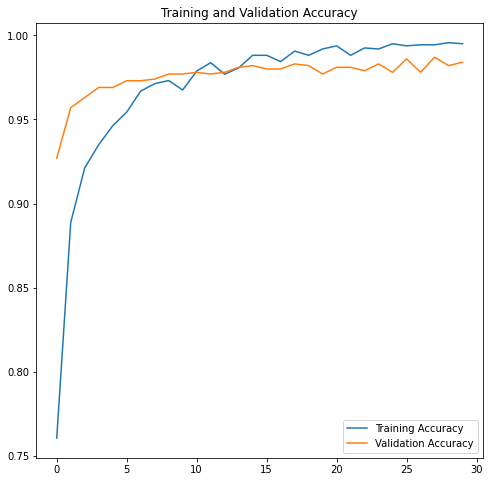

In [86]:
plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')